# Exploration Notebook for Louvain (UCI-ID 50, Image Segmentation)

## Imports

In [1]:

# %load_ext autoreload
# %autoreload 2

In [2]:
import networkx as nx
import pandas as pd
import seaborn as sb
import umap.plot
from community import community_louvain
from ucimlrepo import fetch_ucirepo

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, erro

In [3]:
import sys

sys.path.append("../")
import visualization
import processing
from embedding_obj import EmbeddingObj


## Workflow Example

In [4]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/50/image+segmentation)
image_segmentation = fetch_ucirepo(id=50)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets)

target_feature = "saturation-mean"
labels = pd.Categorical(y["class"]).codes

X.head()

,region-centroid-col,region-centroid-row,region-pixel-count,short-line-density-5,short-line-density-2,vedge-mean,vedge-sd,hedge-mean,hedge-sd,intensity-mean,rawred-mean,rawblue-mean,rawgreen-mean,exred-mean,exblue-mean,exgreen-mean,value-mean,saturation-mean,hue-mean
0,140.0,125.0,9.0,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333333,7.666667,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,188.0,133.0,9.0,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666667,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,105.0,139.0,9.0,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333333,3.333333,-7.666667,7.555555,0.532628,-0.965946
3,34.0,137.0,9.0,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,39.0,111.0,9.0,0.0,0.0,0.722222,0.374074,0.888889,0.429630,6.037037,7.000000,7.666667,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [5]:
# # fetch dataset (available at https://archive.ics.uci.edu/dataset/186/wine+quality)
# image_segmentation = fetch_ucirepo(id=186)
#
# # data (as pandas dataframes)
# X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
# y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")
#
# target_feature = "pH"
# labels = pd.Categorical(y["quality"]).codes
#
# X.head()

<Axes: ylabel='Count'>

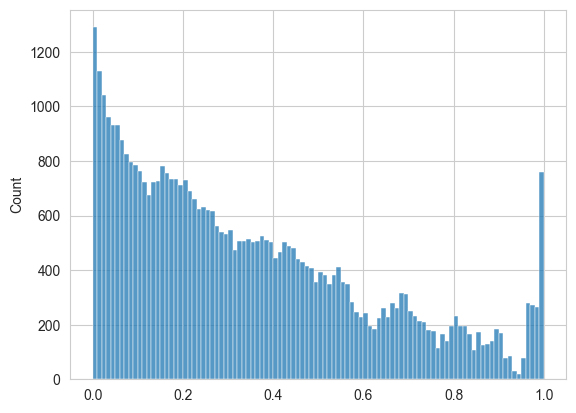

In [6]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [target_feature])
sb.histplot(connectivity_pairwise.flatten(), bins=100)

### 0. Compute initial UMAP-Embedding

In [7]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

graph_knn_feat, edge_weights_knn_feat = processing.compute_graph_weights(X, [
    target_feature],
                                                                         n_neighbors=5)

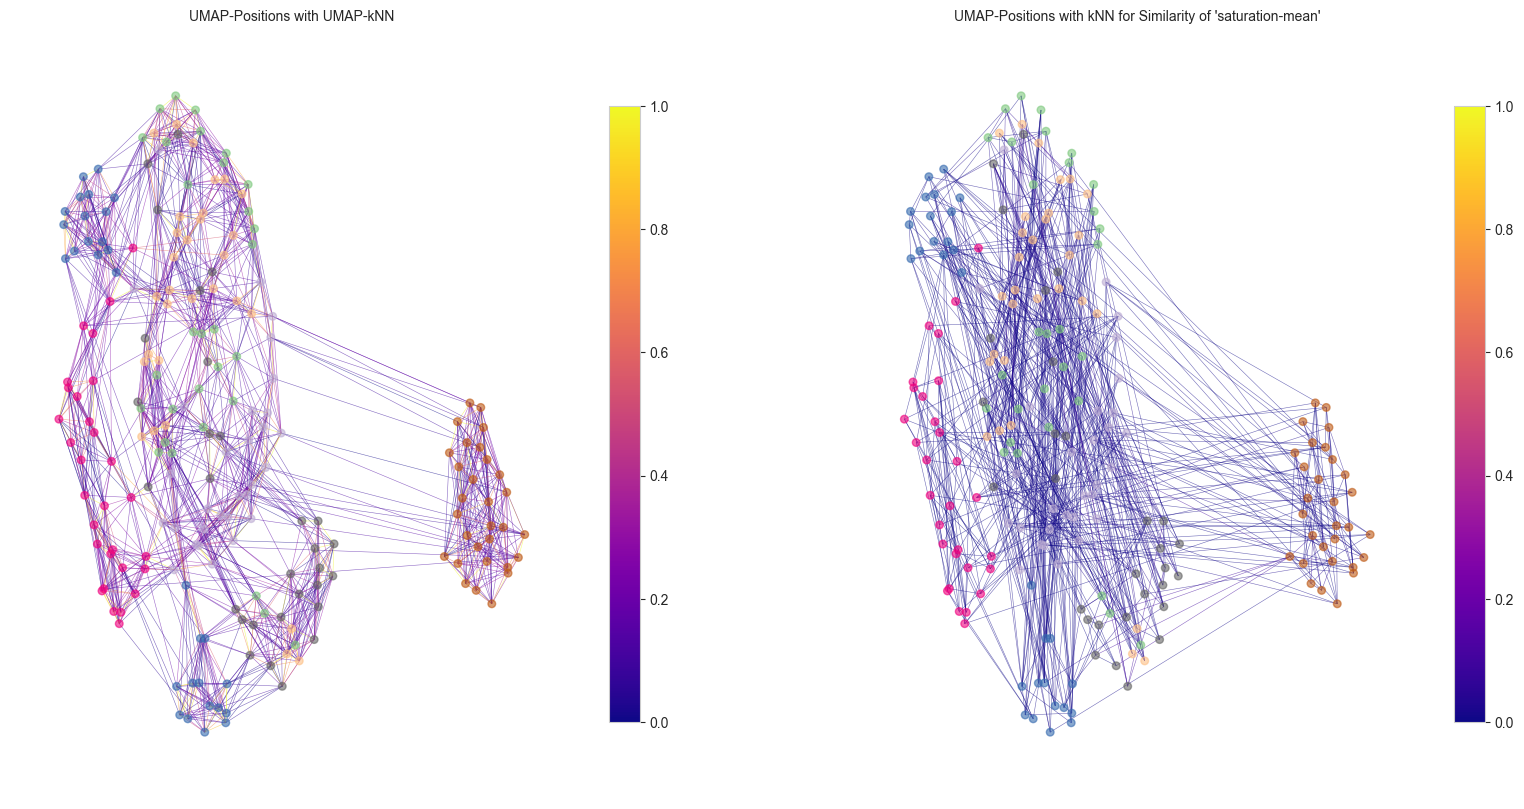

In [9]:
knn_list = [EmbeddingObj(graph=graph_umap_knn, embedding=umap_embedding,
                         edge_weights=edge_weights_umap_knn,
                         title="UMAP-Positions with UMAP-kNN",
                         labels={i: labels[i] for i in range(len(labels))}),
            EmbeddingObj(graph=graph_knn_feat, embedding=umap_embedding,
                         edge_weights=edge_weights_knn_feat,
                         title=f"UMAP-Positions with kNN for Similarity of '{target_feature}'",
                         labels={i: labels[i] for i in range(len(labels))})
            ]

visualization.display_graphs(knn_list,
                             figsize_columns=2,
                             figsize=(20, 10))

In [10]:
for embedding_obj in knn_list:
    # compute the best partition
    embedding_obj.com_partition = community_louvain.best_partition(
        embedding_obj.sim_graph)

    embedding_obj.labels = embedding_obj.com_partition


### 1. Compute modified Embeddings

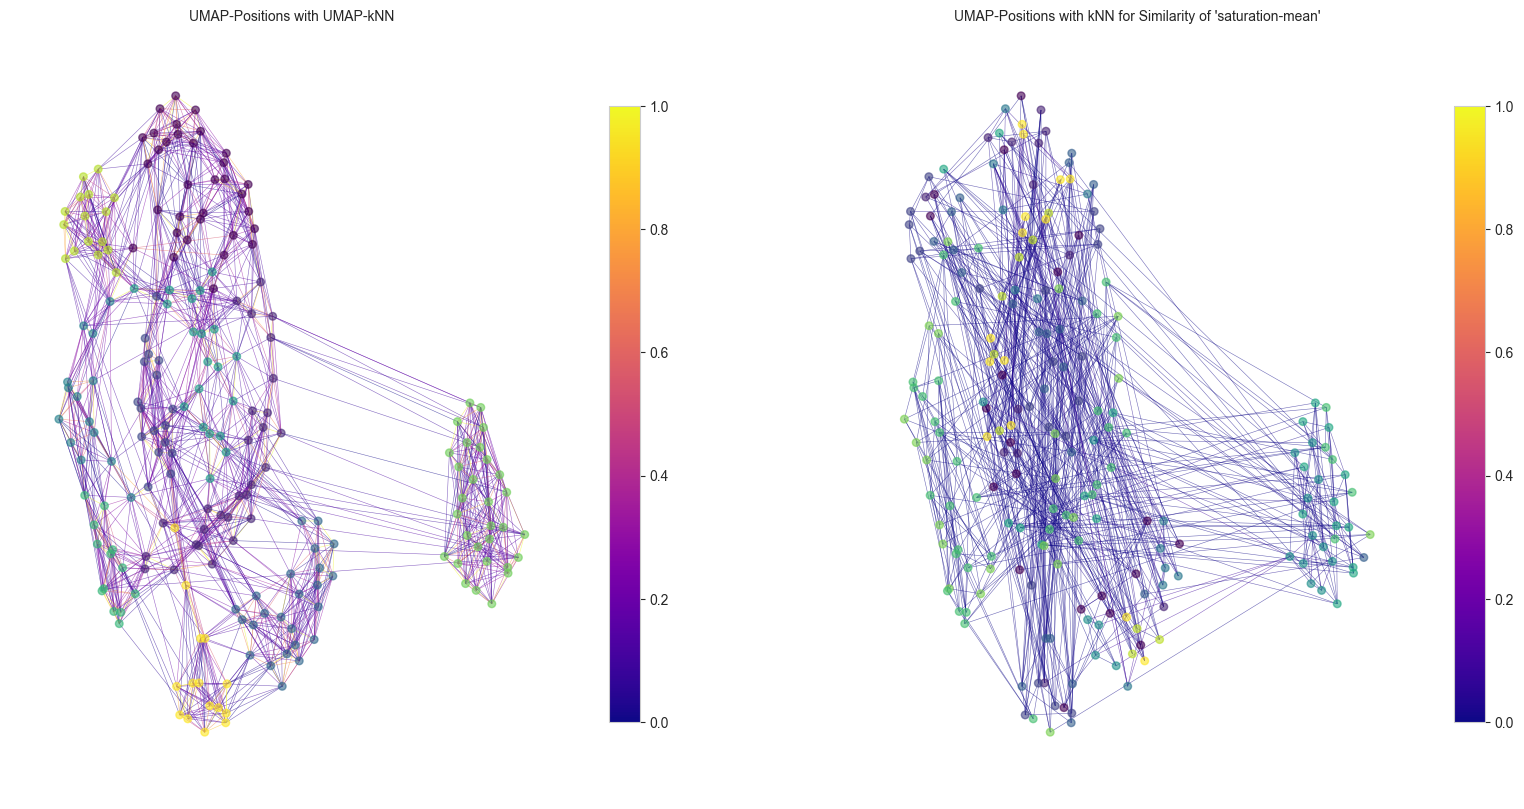

In [11]:
visualization.display_graphs(knn_list,
                             figsize_columns=2,
                             figsize=(20, 10),
                             cmap='viridis')

### 1. Compute modified Embeddings

In [12]:


import networkx as nx
import numpy as np
import numpy.typing as npt
from community import community_louvain
from sklearn.metrics import pairwise_distances  # type: ignore
from sklearn.neighbors import kneighbors_graph  # type: ignore
from sklearn.preprocessing import MinMaxScaler  # type: ignore

from embedding_obj import EmbeddingObj  # type: ignore


def compute_local_force_directed(
        graph: nx.Graph, initial_pos: npt.NDArray[np.float32], iterations: list[int]
) -> list[EmbeddingObj]:
    embeddings = []
    embedding_dict = {i: initial_pos[i] for i in range(len(initial_pos))}

    # compute the best partition
    partition_dict = community_louvain.best_partition(graph)
    partition_values = set(partition_dict.values())

    partition_values = list(partition_values)[:2]

    for iteration in iterations:
        print("------------------------------------------------------------")
        print("Computing modified embedding for iteration: ", iteration)

        iteration_embedding_dict = embedding_dict

        for partition in partition_values:
            subgraph = graph.subgraph(
                [node for node, part in partition_dict.items() if part == partition]
            )

            subgraph_pos = {node: initial_pos[node] for node in subgraph.nodes}

            # subgraph_updated_pos = nx.spring_layout(
            #     subgraph,
            #     pos=subgraph_pos,
            #     iterations=iteration,
            #     threshold=0.0001,
            #     weight="weight",
            #     seed=0,
            # )

            subgraph_updated_pos = nx.forceatlas2_layout(
                subgraph,
                pos=subgraph_pos,
                max_iter=iteration,
                weight="weight",
                seed=0,
            )

            for node in subgraph.nodes():
                iteration_embedding_dict[node] = subgraph_updated_pos[node]

        emb = EmbeddingObj(
            graph,
            np.array(list(iteration_embedding_dict.values())),
            np.array([]),
            labels=partition_dict,
        )

        emb.obj_id = iteration
        emb.title = "Position after " + str(iteration) + " iterations"
        embeddings.append(emb)

        print("Computation finished")
        print("------------------------------------------------------------")

    return embeddings

In [13]:
from sklearn.metrics import pairwise_distances  # type: ignore

pairwise_dists = processing.compute_pairwise_dist(X, [target_feature])

connectivity_umap_knn_nx = nx.Graph(connectivity_umap_knn)

for u, v in connectivity_umap_knn_nx.edges():
    connectivity_umap_knn_nx[u][v]["weight"] = pairwise_dists[u][v]

embeddings = compute_local_force_directed(connectivity_umap_knn_nx, umap_embedding,
                                          [1, 2, 5, 10])

------------------------------------------------------------
Computing modified embedding for iteration:  1


AttributeError: module 'networkx' has no attribute 'forceatlas2_layout'

In [90]:
# embeddings = processing.fit(X, umap_embedding, [target_feature],
#                             iterations=[1, 2, 5, 10], method="local-force-directed",
#                             knn_graph=nx.Graph(connectivity_umap_knn))

D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)
D:\Software-Projekte\Uni\modDR\src\visualization.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(cbar_labels)


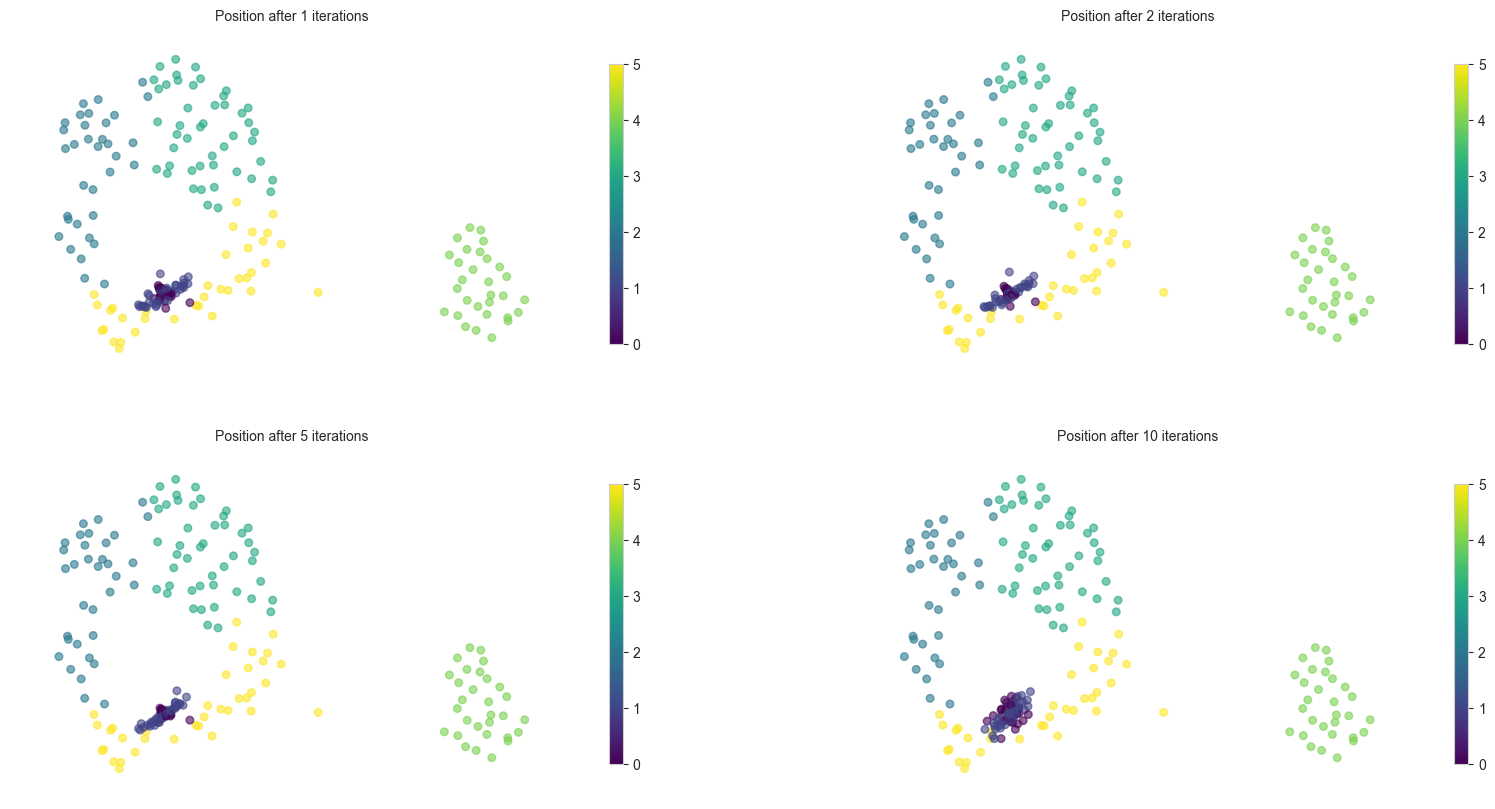

In [91]:
partition_values = set(embeddings[0].labels.values())

visualization.display_graphs(embeddings,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=False,
                             cmap='viridis',
                             cbar_labels=partition_values)